## *Hmong Opium Package*

![](PXL_20240613_105950267.jpg){ fig-align="center" width="60%"}

In [2]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# this is just a definition of a function that we will be using for sampling from the model and
# creating plots of the samples


def plot_from_nodes(
    nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins=20
):
    """
    The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
     and plots histograms for specified nodes. The function then returns the processed DataFrame.
     Parameters:
     - nodes: Dictionary of nodes containing data.
     - filters: Optional dictionary to filter the data based on specified conditions.
     - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
     - bins: Number of bins for the histograms (default is 20).

     Returns:
     - DataFrame of the processed values.
    """

    values = {
        key: nodes[key]["value"].float().detach().cpu().numpy()
        for key in nodes.keys()
        if nodes[key]["name"] != "samples"
    }

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color="blue", density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel("value")
        plt.ylabel("frequency")
        sns.despine()
        plt.show()

    return valuesDF

In [4]:
def weight(posterior: List[float], base=2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(
        x, 1, 1
    )  # def. of a uniform distribution given the size of the posterior

    entropy_uniform = entropy(uniform, base=base)  # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base)  # entropy H(p)
    return 1 - entropy_posterior / entropy_uniform  # weight = 1 - H(p)/H(uniform)

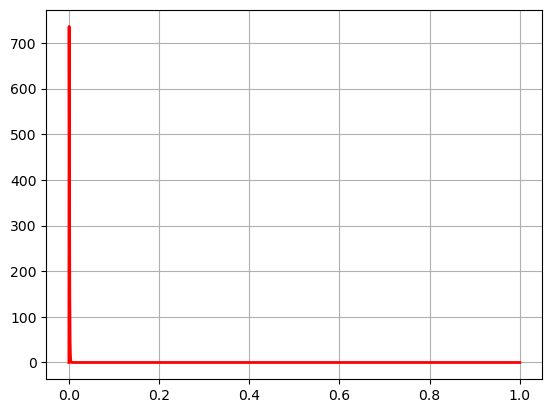

In [97]:
# beta dist check

x = torch.linspace(0, 1, 10000)
pdf_values = dist.Beta(2, 2000).log_prob(x).exp().numpy()
plt.plot(x.numpy(), pdf_values, "r-", linewidth=2)

plt.grid(True)
plt.show()

The first model represents the RMP that a random person from population of Minneapolis (1992) is a smuggler given that they received a package, with the division on Hmong and not Hmong.

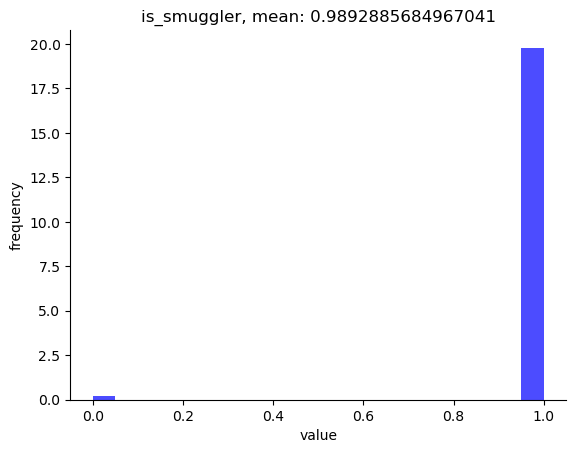

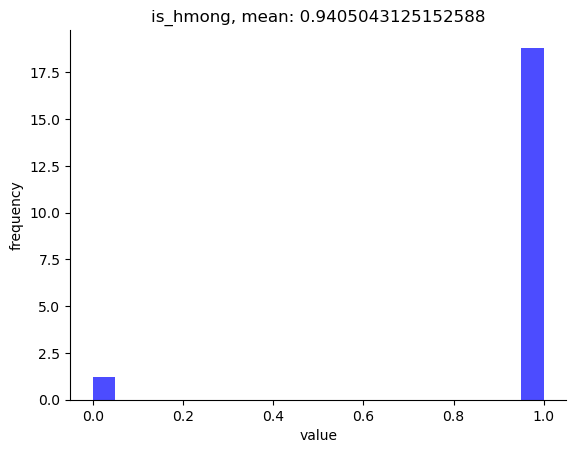

,data,pr_smuggler,pr_package,is_smuggler,is_hmong,pr_package_if_smuggler,has_package
0,0.0,0.970465,0.976145,1.0,0.0,0.937675,1.0
1,1.0,0.989935,0.978799,1.0,1.0,0.974202,1.0
2,2.0,0.992280,0.990099,1.0,1.0,0.998336,1.0
3,3.0,0.985973,0.988713,1.0,1.0,0.848710,1.0
4,4.0,0.994204,0.992950,1.0,1.0,0.957645,1.0
...,...,...,...,...,...,...,...
99995,99995.0,0.985634,0.960281,1.0,1.0,0.967595,1.0
99996,99996.0,0.978510,0.987825,1.0,1.0,0.914259,1.0
99997,99997.0,0.986635,0.991705,1.0,1.0,0.868359,1.0
99998,99998.0,0.997791,0.985126,1.0,1.0,0.918342,1.0


In [102]:
def opium_package_general():

    pr_Hmong = 0.06  # the actual size of the Hmong community

    pr_Hmong_if_smuggler = 0.95  # the value given in the example (we might consider a more uncertain variable here)

    pr_smuggler = pyro.sample("pr_smuggler", dist.Beta(200, 2))
    pr_package = pyro.sample("pr_package", dist.Beta(200, 3))

    # is_hmong = pyro.sample("is_hmong", dist.Bernoulli(pr_Hmong))

    is_smuggler = pyro.sample("is_smuggler", dist.Bernoulli(pr_smuggler))

    pr_Hmong_given_smuggler = (
        is_smuggler * pr_Hmong_if_smuggler + (1 - is_smuggler) * pr_Hmong
    )

    is_hmong = pyro.sample("is_hmong", dist.Bernoulli(pr_Hmong_given_smuggler))

    pr_package_if_smuggler = pyro.sample(
        "pr_package_if_smuggler", dist.Beta(20, 2)
    )  # assumption that they do not always receive a package (mistake or intentional use of different address)
    actual_pr_package = (
        is_smuggler * pr_package_if_smuggler + (1 - is_smuggler) * pr_package
    )

    has_package = pyro.sample("has_package", dist.Bernoulli(actual_pr_package))


# pr_hmong_if_smuggler_updated = is_smuggler * pr_Hmong_if_smuggler + (1 - is_smuggler) * pr_Hmong
# is_hmong_if_smuggler = pyro.sample("is_hmong_if_smuggler", dist.Bernoulli(pr_hmong_if_smuggler_updated))

# package = pyro.sample("package", dist.Bernoulli(prob_package))
# smuggler = pyro.sample("smuggler", dist.Bernoulli(prob_smuggler))


pyro.render_model(opium_package_general)


with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        opium_package_general()


nodes = tr.trace.nodes


plot_from_nodes(
    nodes, filters={"has_package": 1.0}, nodes_to_plot=["is_smuggler", "is_hmong"]
)

Example when a person that received a package is Hmong:

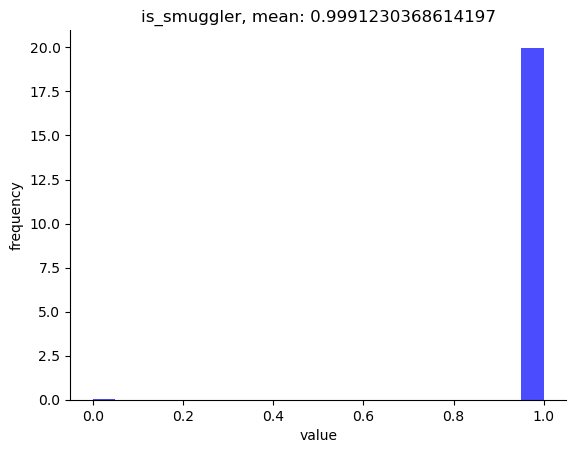

,data,pr_smuggler,pr_package,is_smuggler,is_hmong,pr_package_if_smuggler,has_package
1,1.0,0.989935,0.978799,1.0,1.0,0.974202,1.0
2,2.0,0.992280,0.990099,1.0,1.0,0.998336,1.0
3,3.0,0.985973,0.988713,1.0,1.0,0.848710,1.0
4,4.0,0.994204,0.992950,1.0,1.0,0.957645,1.0
5,5.0,0.996148,0.987034,1.0,1.0,0.940053,1.0
...,...,...,...,...,...,...,...
99995,99995.0,0.985634,0.960281,1.0,1.0,0.967595,1.0
99996,99996.0,0.978510,0.987825,1.0,1.0,0.914259,1.0
99997,99997.0,0.986635,0.991705,1.0,1.0,0.868359,1.0
99998,99998.0,0.997791,0.985126,1.0,1.0,0.918342,1.0


In [103]:
plot_from_nodes(
    nodes, filters={"has_package": 1.0, "is_hmong": 1.0}, nodes_to_plot=["is_smuggler"]
)

Example when a person that received a package is not Hmong:

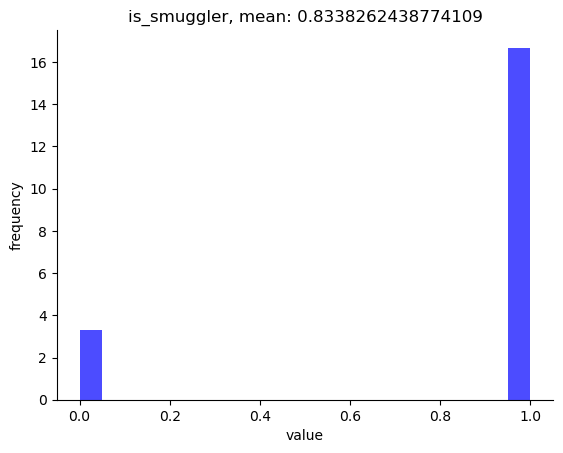

,data,pr_smuggler,pr_package,is_smuggler,is_hmong,pr_package_if_smuggler,has_package
0,0.0,0.970465,0.976145,1.0,0.0,0.937675,1.0
11,11.0,0.993885,0.987891,1.0,0.0,0.968000,1.0
38,38.0,0.988114,0.983640,1.0,0.0,0.816755,1.0
50,50.0,0.990510,0.997534,1.0,0.0,0.814341,1.0
135,135.0,0.978843,0.981906,1.0,0.0,0.962812,1.0
...,...,...,...,...,...,...,...
99968,99968.0,0.994268,0.979977,0.0,0.0,0.884497,1.0
99969,99969.0,0.991264,0.988698,1.0,0.0,0.827272,1.0
99970,99970.0,0.988786,0.975105,1.0,0.0,0.947066,1.0
99973,99973.0,0.993979,0.971711,1.0,0.0,0.798860,1.0


In [104]:
plot_from_nodes(
    nodes, filters={"has_package": 1.0, "is_hmong": 0}, nodes_to_plot=["is_smuggler"]
)

The next step might be introducing more uncertainty in the probability that 95% of smugglers are Hmong.

Also, maybe the probability that a random person, when they are Hmong, will receive a package is larger than when they are not Hmong?